# Predicting Movie Ratings using Tags - Clustering & Word embeddings

## Load Libraries and Data

In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#import datasets
rating = pd.read_csv('rating.csv')
tag = pd.read_csv('tag.csv')
movie = pd.read_csv('movie.csv')

In [5]:
print ('Shape of rating data is', rating.shape)
print ('Shape of tag data is', tag.shape)
print ('Shape of movie data is', movie.shape)

Shape of rating data is (20000263, 4)
Shape of tag data is (465564, 4)
Shape of movie data is (27278, 3)


In [6]:
#take a sample of data for analysis
tags = tag.sample(frac=0.2)
ratings = rating.sample(frac=0.2)

In [7]:
tags.head()

,userId,movieId,tag,timestamp
165878,49129,79132,dreamlike,2011-04-27 22:51:28
248071,71833,4,characters,2012-04-27 21:26:49
324883,96182,41285,Scarlett Johansson,2012-09-22 06:27:22
359630,110357,88877,funny,2013-07-28 03:05:35
41591,10514,80166,Jason Bateman,2014-01-04 01:56:33


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
10935670,75632,1617,3.0,2000-08-02 23:31:09
2256521,15339,6378,4.0,2014-09-06 14:50:27
5980454,41209,1907,5.0,2009-12-25 17:18:29
3492275,23811,5151,3.5,2005-12-14 20:39:57
9364260,64788,1258,4.0,2001-07-04 13:11:05


In [9]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
#drop timestamp in ratings as it's not useful for our prediction
ratings = ratings.drop(['timestamp'],axis = 1)

In [11]:
ratings.head()

,userId,movieId,rating
10935670,75632,1617,3.0
2256521,15339,6378,4.0
5980454,41209,1907,5.0
3492275,23811,5151,3.5
9364260,64788,1258,4.0


In [58]:
#merge dataset
df = pd.merge(ratings,tags,how='inner')

In [59]:
print ('Shape of the joint data is',df.shape)
print (df.head())

Shape of the joint data is (15349, 5)
   userId  movieId  rating                        tag            timestamp
0    7729     5349     4.5                 Comic book  2006-04-02 03:41:03
1    6233   112852     2.0  underdeveloped characters  2014-08-19 19:25:51
2   93414    99728     3.5                 Emma Stone  2014-07-16 02:24:50
3    2702     4776     4.5                 corruption  2013-09-07 13:47:11
4   22377    91094     2.5                    musical  2013-07-24 04:17:27


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15349 entries, 0 to 15348
Data columns (total 5 columns):
userId       15349 non-null int64
movieId      15349 non-null int64
rating       15349 non-null float64
tag          15348 non-null object
timestamp    15349 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 719.5+ KB


## Data Cleaning

In [61]:
for col in df.columns:
    print(col, df[col].nunique())

userId 2243
movieId 4153
rating 10
tag 5251
timestamp 14992


Text(0.5, 1.0, 'Movie rating distribution')

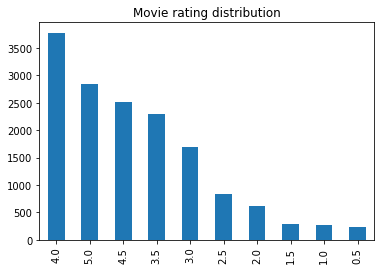

In [62]:
df['rating'].value_counts().plot(kind='bar')
plt.title('Movie rating distribution')

In [63]:
tag_rating = df['rating'].groupby(df['tag']).agg(['mean','count']).round(2).reset_index()
tag_rating.head(10)

,tag,mean,count
0,(s)vcd,5.00,1
1,*Good* Musicals,4.25,2
2,007,3.62,4
3,06 Oscar Nominated Best Movie,2.50,1
4,1,2.00,2
5,10-2-2008,3.50,1
6,10.06.06,4.00,1
7,100 Essential Female Performances,4.25,2
8,100 Greatest Movies,4.17,3
9,1305,3.50,1


In [64]:
#clean the text data, delete special characters and convert to lower case

df['tag'] = df['tag'].apply(lambda x: str(x))
df['tag'] = df['tag'].map(lambda x: re.sub(r'([^\s\w]|_)+', '', x))
df['tag'] = df['tag'].str.lower()

In [65]:
#relabel ratings and categorize them into two levels: high rating for rating>4 and low rating for rating<4

df['rating'] = df['rating'].apply(lambda x: 1 if x < 4 else 0)

In [66]:
# text processing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tag'])
sequences = tokenizer.texts_to_sequences(df['tag'])

word_index = tokenizer.word_index
#print('Found %s unique tokens.' % len(word_index))

#use pad_sequences to ensure that all sequences in a list have the same length
pseq = pad_sequences(sequences)
pdseq = pd.DataFrame(pseq)

In [67]:
#Convert timestamp in seconds to datetime format

#df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
#df['timestamp'].astype('datetime64[ns]')

In [68]:

vectorizer = CountVectorizer(stop_words='english',decode_error='ignore', analyzer='word')
corpus = df['tag'].values
word_vec = vectorizer.fit_transform(corpus.ravel())
word_vec = word_vec.toarray()

words = vectorizer.get_feature_names()
print("number of words in plot summary: ", len(words))
pdwordvec = pd.DataFrame(word_vec,columns=words)

number of words in plot summary:  5106


In [69]:
pdwordvec.head()

,007,06,10,100,1000,100606,1022008,1305,16th,17th,...,zizeks,zoe,zombie,zombies,zooey,zucker,zwick,æra,økonomisk,øvrigt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
df.shape

(15349, 5)

## K-means clustering words using GloVe embedding

Decided to use the pre-trained model as I do not have sufficient data to create my own embedding given all tags.

In [25]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [26]:
#Return a new array of given shape, filled with zeros.
embedding_matrix = np.zeros((len(words), 100))

for i in range(len(words)):
    embedding_vector = embeddings_index.get(words[i])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
pdembedding = pd.DataFrame(embedding_matrix.T,columns=words) #Same as self.transpose(), except that self is returned if self.ndim < 2.

### Prepare Data for Clustering

In [27]:
#Cluster word embeddings data 
kmeans = KMeans(init='k-means++', n_clusters=300, n_init=10)
kmeans.fit(pdembedding.T)

#Get cluster labels
clusters = kmeans.labels_

#Add columns to data for each cluster
for i in range(max(clusters)+1):
 df[i] = 0

#If word is in data row, label the associated cluster accordingly with 1
for i in range(len(pdwordvec.columns)):
    column = pdwordvec.columns[i]
    index = pdwordvec[column].loc[pdwordvec[column] > 0, ].index
    for ii in range(len(index)):
        df.loc[index[ii],clusters[i]] = 1

In [28]:
df.shape

(15349, 305)

In [29]:
#drop tag column as we have vecterized words

df = df.drop(['tag'],axis = 1)

Include movie gerne in the model as it might be useful for prediction

In [30]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
#split the genre column in movie data
genre_list = movie.set_index('movieId').genres.str.split(r'|', expand=True).stack().reset_index(level=1,drop=True).to_frame('genre')

In [32]:
genre_list.head()

,genre
movieId,
1,Adventure
1,Animation
1,Children
1,Comedy
1,Fantasy


In [33]:
#Use one-hot encoding grouped by genre 
genres = pd.get_dummies(genre_list, prefix='genre', columns=['genre']).groupby(level=0).sum()
genres.head()

,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
#Drop unnecessary field, if all genres are 0 then it means no genres are listed. 
genres = genres.drop(['genre_(no genres listed)'], axis=1)

In [35]:
#Joın data by movieId
#genres['movieId'] = genres.index
df = pd.merge(df, genres, on='movieId', how='left')

In [36]:
#Assign variables as categorical using one hot encoding
userid_encoding = pd.get_dummies(df['userId'],prefix='userid')
df = df.drop(['userId'], axis=1)
df = pd.concat([df, userid_encoding], axis=1)

movieid_encoding = pd.get_dummies(df['movieId'],prefix='movieid')
df = df.drop(['movieId'], axis=1)
df = pd.concat([df, movieid_encoding], axis=1)

In [37]:
df.head()

,rating,timestamp,0,1,2,3,4,5,6,7,...,movieid_125535,movieid_125786,movieid_126591,movieid_128721,movieid_128989,movieid_129235,movieid_129857,movieid_130071,movieid_130073,movieid_130856
0,0,2006-04-02 03:41:03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2014-08-19 19:25:51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2014-07-16 02:24:50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2013-09-07 13:47:11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2013-07-24 04:17:27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#fill NAs
df = df.fillna(np.nan)

## Machine Learning Models

In [39]:
#seperate test and train data, use the last 12-month for testing

train = df[(df['timestamp'] < '2014-03-30') ]
test = df[(df['timestamp'] >= '2014-03-30') ]

In [40]:
print ("Number of rows in test data set:", (len(test)))
print ("Number of rows in training data set:",(len(train)))

Number of rows in test data set: 1937
Number of rows in training data set: 13412


In [41]:
#remove timestamp as it won't be needed for modeling
train = train.drop(['timestamp'], axis=1)
test = test.drop(['timestamp'], axis=1)

In [42]:
#Define target and predictor variables
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating'], axis=1)
x_test = test.drop(['rating'], axis=1)

### 1. Baseline model

In [43]:
#build the baseline model
#classification problem, you can select the class that has the most observations and use that class as the result for all predictions

baseline_accuracy = float(y_test.value_counts().max())/y_test.value_counts().sum()
print ("Accuracy of the baseline model is: ", np.round(baseline_accuracy,2))

Accuracy of the baseline model is:  0.62


### 2. Logistic regression

In [44]:
# logistic regression

logreg = LogReg(C = 1, class_weight='balanced')
logreg.fit (x_train, y_train)
y_predlog = logreg.predict_proba(x_test)
R2_log = logreg.score(x_test,y_test) 
print ("Accuracy of the test set for log. reg. is: ", np.round(R2_log,2))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of the test set for log. reg. is:  0.68


### 3. Random forest

In [45]:
# Random forest

rfc = RandomForestClassifier(class_weight='balanced')#address the imbalanced in target variable
rfc.set_params(n_estimators=100)
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [46]:
R2_rfc = rfc.score(x_test,y_test) 
print ("Accuracy of the test set for random forest is: ", np.round(R2_rfc,2))

Accuracy of the test set for random forest is:  0.69


In [47]:
#plot the feature accuracy

rfc_plot = pd.DataFrame({'features': x_train.columns,
                        'importances': rfc.feature_importances_})
rfc_plot = rfc_plot.sort_values('importances', ascending=False)[:20]

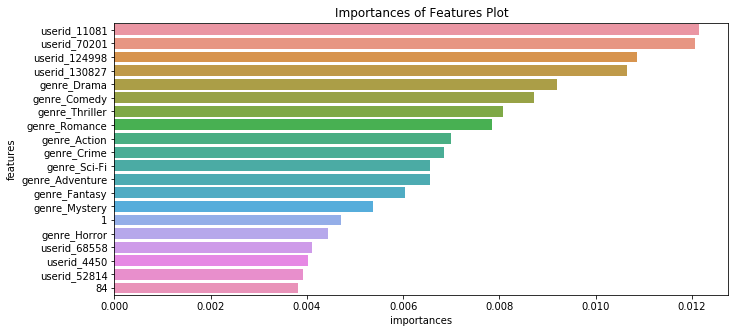

In [48]:
plt.figure(figsize=[11,5])
sns.barplot(x = rfc_plot.importances, y = rfc_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [49]:
print(rfc_plot.min())
print(rfc_plot.max())

importances    0.003822
dtype: float64
importances    0.012149
dtype: float64


#### Visualize the model performance on different levels of depth

In [50]:
depth = range(1, 100, 10)

train_acc = []
test_acc = []

for i in depth:
    rfc.set_params(n_estimators=100, max_depth=i)
    rfc.fit(x_train, y_train)
    train_acc.append(rfc.score(x_train, y_train))
    test_acc.append(rfc.score(x_test, y_test))

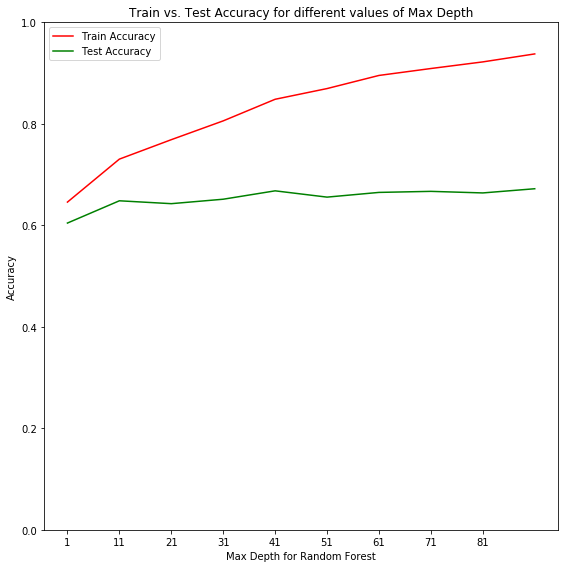

Accuracy is maximum at max depth value of 91 and yields accuracy of 0.67


In [51]:
#Visualize accuracy for different regularization parameters

plt.figure(figsize=(8,8))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(9), depth)
plt.xlabel('Max Depth for Random Forest')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Train vs. Test Accuracy for different values of Max Depth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at max depth value of', depth[np.argmax(test_acc)],
                'and yields accuracy of', round(max(test_acc), 2))

### 4. XGboost

In [52]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth=30, learning_rate=0.1) 
                       
xgb_model.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_train, y_train), (x_test, y_test)])  

[0]	validation_0-error:0.280942	validation_1-error:0.356737
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27028	validation_1-error:0.345896
[2]	validation_0-error:0.265956	validation_1-error:0.340217
[3]	validation_0-error:0.260364	validation_1-error:0.342798
[4]	validation_0-error:0.257829	validation_1-error:0.339701
[5]	validation_0-error:0.254772	validation_1-error:0.343314
[6]	validation_0-error:0.255219	validation_1-error:0.339184
[7]	validation_0-error:0.254921	validation_1-error:0.33557
[8]	validation_0-error:0.247018	validation_1-error:0.338668
[9]	validation_0-error:0.246794	validation_1-error:0.341249
[10]	validation_0-error:0.24754	validation_1-error:0.340217
[11]	validation_0-error:0.247689	validation_1-error:0.334022
[12]	validation_0-error:0.248732	validation_1-error:0.334022
[13]	validation_0-error:0.246645	validation_1-error:0.33505

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [54]:
R2_xgb = xgb_model.score(x_test,y_test) 
print ("Accuracy of the test set for XGBoost model is: ", np.round(R2_xgb,2))

Accuracy of the test set for XGBoost model is:  0.68


In [56]:
#print classification report

prediction_xgb = xgb_model.predict(x_test)
print(classification_report(y_test, prediction_xgb))

              precision    recall  f1-score   support

           0       0.68      0.92      0.78      1200
           1       0.69      0.28      0.40       737

   micro avg       0.68      0.68      0.68      1937
   macro avg       0.68      0.60      0.59      1937
weighted avg       0.68      0.68      0.63      1937



## Conclusion

The dataset is provided by MovieLens that contains data 20M datapoint about users, movies, ratings, tags and time. Traditional approaches for this type of problem could be building recommender systems using content-based filtering, user-base filtering or Collaborative filtering. In this project, instead, I wanted to predict movie ratings using tags(metadata) that were given by users.

After looking into the data, I decided to treat it as a classification problem by grouping rating > 4 as 'satisfied' and rating <= 4 as 'not satisfied'. After data cleaning and some text processing, I was able to build machine learning models using userID, movieID, movie genre and tags clustered using GloVe word embeddings.

Based on the above models, XGboost achieved same accuracy as logistic regression with R2=0.68. Random forest got the highest accuracy with 0.69 R2, which is 0.7 higher than baseline model. In future study, a deep learning model(or emsemble model) should be considered for improving and achieving higher predicting results. 

<br>
<br>
<br>
<br>
-- project inspired by @emerdem 